# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import tensorflow as tf
import time
import seaborn as sns
from collections import Counter
import time


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable

images='datasets/flickr/Images'

all_images = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_images)))


The total images present in the dataset: 8091


In [3]:
#Visualise both the images & text present in the dataset

all_images

['datasets/flickr/Images/1000268201_693b08cb0e.jpg',
 'datasets/flickr/Images/1001773457_577c3a7d70.jpg',
 'datasets/flickr/Images/1002674143_1b742ab4b8.jpg',
 'datasets/flickr/Images/1003163366_44323f5815.jpg',
 'datasets/flickr/Images/1007129816_e794419615.jpg',
 'datasets/flickr/Images/1007320043_627395c3d8.jpg',
 'datasets/flickr/Images/1009434119_febe49276a.jpg',
 'datasets/flickr/Images/1012212859_01547e3f17.jpg',
 'datasets/flickr/Images/1015118661_980735411b.jpg',
 'datasets/flickr/Images/1015584366_dfcec3c85a.jpg',
 'datasets/flickr/Images/101654506_8eb26cfb60.jpg',
 'datasets/flickr/Images/101669240_b2d3e7f17b.jpg',
 'datasets/flickr/Images/1016887272_03199f49c4.jpg',
 'datasets/flickr/Images/1019077836_6fc9b15408.jpg',
 'datasets/flickr/Images/1019604187_d087bf9a5f.jpg',
 'datasets/flickr/Images/1020651753_06077ec457.jpg',
 'datasets/flickr/Images/1022454332_6af2c1449a.jpg',
 'datasets/flickr/Images/1022454428_b6b660a67b.jpg',
 'datasets/flickr/Images/1022975728_75515238d8.j

In [4]:
#Import the dataset and read the text file into a seperate variable

text_file = "datasets/flickr/captions.txt"

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    print(text)
    file.close()
    return text

doc = load_doc(text_file)
print(doc[:300])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
img = 'datasets/flickr/Images/'

def store_func(text):
    all_img_id=[]
    annotations=[]
    all_img_vector=[]
    text=text.splitlines()[1:]
    for line in text:
        co_idx=line.index(",")
        im_id,im_cap=line[:co_idx],line[co_idx+1:]
        all_img_id.append(im_id)
        annotations.append(im_cap)
        all_img_vector.append(img+im_id)
    return all_img_id,annotations,all_img_vector

In [6]:
all_img_id,annotations,all_img_vector= store_func(doc)#store all the image id here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,datasets/flickr/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,datasets/flickr/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [7]:
#Create a list which contains all the captions
annotations=list(df['Captions'])

#add the <start> & <end> token to all those captions as well
annotations = df.Captions.apply(lambda s:"<start>"+" "+s+" "+"<end>")

#Create a list which contains all the path to the images
all_img_path=list(df['Path'])
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [8]:
#Create the vocabulary & the counter for the captions
def create_vocabulary(data):
    vocab = []
    for captions in data.Captions.values:
        vocab.extend(captions.split())
    print("Vocabulary Size : {}".format(len(set(vocab))))
    return vocab
vocabulary = create_vocabulary(df)
val_count=Counter(vocabulary)
val_count

Vocabulary Size : 9862


Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

In [9]:
#Visualise the top 30 occuring words in the captions


most_occur = val_count.most_common(30)

print(most_occur)

[('a', 40271), ('.', 34212), ('A', 21481), ('in', 18961), ('the', 15328), ('on', 10729), ('is', 9345), ('and', 8850), ('dog', 7982), ('with', 7760), ('man', 6828), ('of', 6712), ('Two', 3962), ('white', 3875), ('black', 3696), ('are', 3503), ('boy', 3442), ('woman', 3227), ('girl', 3217), (',', 3210), ('to', 3173), ('wearing', 3061), ('The', 2920), ('at', 2904), ('water', 2774), ('red', 2660), ('brown', 2475), ('people', 2442), ('young', 2431), ('."', 2365)]


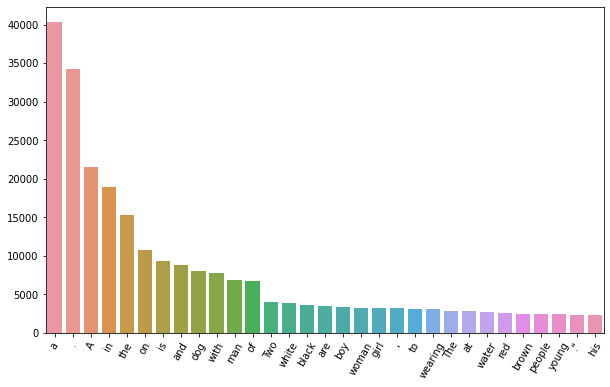

In [10]:
def top_count_graph(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
top_count_graph(val_count,30)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [11]:
# create the tokenizer

topT = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=topT+1,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [12]:
# Create word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

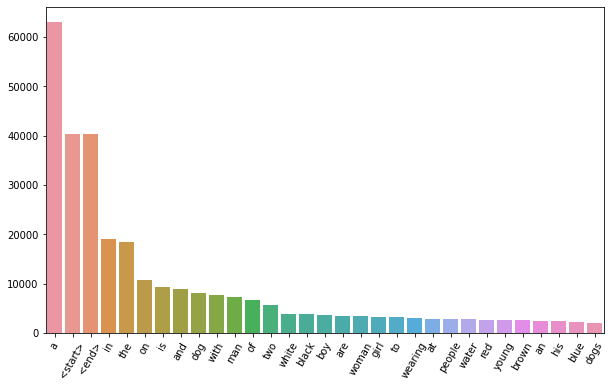

In [13]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

top_count_graph(tokenizer.word_counts,30)

In [14]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
def max_func(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = max_func(train_seqs)
def padding_func(train_seqs,max_length,padding_type):
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
    return cap_vector
cap_vector= padding_func(train_seqs,max_length,'post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [15]:
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [16]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [17]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)




In [18]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [19]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [20]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

image_features_extract_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [00:54<00:00,  4.68it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [22]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [23]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [24]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [25]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [26]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [27]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [28]:
embedding_dim = 256 
units = 512
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [29]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #self.dense = #build your Dense layer with relu activation
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)
        
    def call(self, features):
        #features =  # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [30]:
encoder=Encoder(embedding_dim)

### Attention model

In [31]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights


In [32]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Decoder

In [33]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)   
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x)) #shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [34]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [35]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [37]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [38]:
checkpoint_path = "Flickr8K/File3/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [40]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [41]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

In [42]:
def test_loss_cal(test_dataset):
    
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
    
        total_loss += t_loss
        avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [43]:
loss_plot = []
test_loss_plot = []
EPOCHS = 2

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

 50%|█████     | 1/2 [05:11<05:11, 311.64s/it]

For epoch: 1, the train loss is 1.194, & test loss is 1.015
Time taken for 1 epoch 311.48579382896423 sec

Test loss has been reduced from 100.000 to 1.015


100%|██████████| 2/2 [08:18<00:00, 249.31s/it]

For epoch: 2, the train loss is 0.939, & test loss is 0.901
Time taken for 1 epoch 186.80625247955322 sec

Test loss has been reduced from 1.015 to 0.901


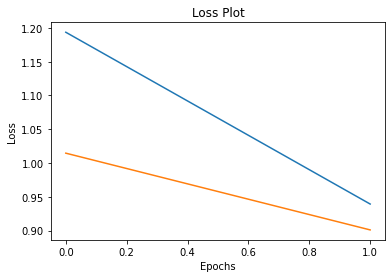

In [44]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [69]:
def evaluate(image):
    max_length= 39
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [70]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


In [71]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [72]:
from nltk.translate.bleu_score import sentence_bleu

In [73]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [77]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score: 40.85166851999189
Real Caption: a black dog jumping off a dock into water
Prediction Caption: a black dog is jumping into a lake


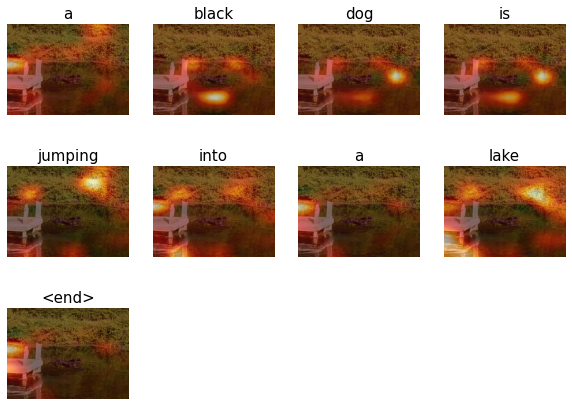

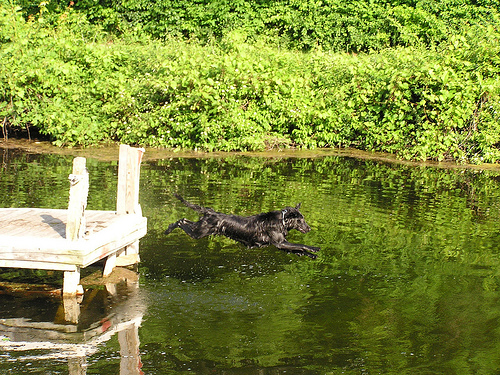

In [78]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

In [ ]:
from gtts import gTTS
from IPython.display import Audio
tts = gTTS("Predicted Caption is: "+ pred_caption) 
tts.save('s.wav')
sound_file = 's.wav'
Audio(sound_file, autoplay=True)